In [247]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from cartopy.io.shapereader import Reader, natural_earth
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import geopandas
from matplotlib.path import Path
import cartopy.feature as cfeature
import matplotlib.patches as patches

In [258]:
def draw_screen_poly( lats, lons):
    '''
    lats:  Latitude list 
    lons:  Longitude list 
    purpose:   Draw a line in the area 
    '''
    x, y =  lons, lats
    xy = list(zip(x,y))
    print(xy)
    poly = plt.Polygon( xy, edgecolor="blue",fc="none", lw=0.6, alpha=1)
    plt.gca().add_patch(poly)
    
def create_map(info):
    """ Create an area of the Tibetan Plateau Lambert Base map of projection 
    Returns:
        ax:  Graph objects 
    """
    ## -- Create drawing space
    proj = ccrs.PlateCarree()  #  Create a coordinate system 
    ref_lat = info['ref_lat']
    ref_lon = info['ref_lon']
    true_lat1 = info['true_lat1']
    true_lat2 = info['true_lat2']
    false_easting = (info['e_we'][0]-1)/2*info['dx']
    false_northing = (info['e_sn'][0]-1)/2*info['dy']
    # print(true_lat1)
    proj_lambert = ccrs.LambertConformal(
                    central_longitude=ref_lon,
                    central_latitude=ref_lat,
                    standard_parallels=(true_lat1,true_lat2),
                    cutoff=-30,
                    false_easting=false_easting,
                    false_northing=false_northing,
                )
    ##  Create a coordinate system 
    fig = plt.figure(figsize=(2, 2), dpi=500)  #  Create a page 
    ax = fig.add_axes([0.1,0.1,0.8,0.8], projection=proj_lambert)  
    ##  Read the Qinghai Tibet Plateau terrain file 

def create_map(info):
    """ Create an area of the Tibetan Plateau Lambert Base map of projection 
    Returns:
        ax:  Graph objects 
    """
    ## -- Create drawing space 
    proj = ccrs.PlateCarree()  #  Create a coordinate system 
    ref_lat = info['ref_lat']
    ref_lon = info['ref_lon']
    true_lat1 = info['true_lat1']
    true_lat2 = info['true_lat2']
    false_easting = (info['e_we'][0]-1)/2*info['dx']
    false_northing = (info['e_sn'][0]-1)/2*info['dy']
    # print(true_lat1)
    proj_lambert = ccrs.LambertConformal(
                    central_longitude=ref_lon,
                    central_latitude=ref_lat,
                    standard_parallels=(true_lat1,true_lat2),
                    cutoff=-30,
                    false_easting=false_easting,
                    false_northing=false_northing,
                )
    
    fig = plt.figure(figsize=(2, 2), dpi=500)  #  Create a page 
    ax = fig.add_axes([0.1,0.1,0.8,0.8], projection=proj_lambert)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    ## -- Set grid properties ,  Don't draw the default label 
    gl=ax.gridlines(draw_labels=True,linestyle=":",linewidth=0.3 ,x_inline=False, y_inline=False,color='k')
    ##  Turn off the latitude and longitude display on the top and right 
    gl.top_labels=False # Close the upper warp and weft label 
    # gl.bottom_labels = False
    # gl.left_labels = False
    gl.right_labels=False
    gl.xformatter = LONGITUDE_FORMATTER  # Convert abscissa to latitude and longitude format 
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator=mticker.FixedLocator(np.arange(60,120,10))
    gl.ylocator=mticker.FixedLocator(np.arange(10,60,10))
    gl.xlabel_style={'size':4}# Modify latitude and longitude font size 
    gl.ylabel_style={'size':4}
    ax.spines['geo'].set_linewidth(0.6)# Adjust the border thickness 
    # ax.set_extent([60, 120, 10, 60], crs=proj)
    # ax.set_extent([0, 2237500*2, 0, 1987500*2], crs=proj_lambert)
    ax.set_extent([0, false_easting*2, 0, false_northing*2], crs=proj_lambert)
    print(false_northing)
    print(false_easting)
    return ax


def get_information(flnm):
    """ according to namelist.wps file , Get the basic information of the map 
    Args:
        flnm ([type]): [description]
    Returns:
        [type]: [description]
    """
    ## getting namelist.wps domain information
    name_dict={}
    with open(flnm) as fr:
        for line in fr:
            if "=" in line:   #  I don't think about the comments here ,  however wps Generally, there is no comment 
                line=line.replace("=","").replace(",","")
                name_dict.update({line.split()[0]: line.split()[1:]})  #  This dictionary can be updated directly 
    dx = float(name_dict["dx"][0])  #  Convert to kilometers 
    dy = float(name_dict["dy"][0])
    max_dom = int(name_dict["max_dom"][0])
    for i in name_dict:
        print(i)
    # print(max_dom)
    parent_grid_ratio = list(map(int, name_dict["parent_grid_ratio"]))
    i_parent_start = list(map(int, name_dict["i_parent_start"]))
    j_parent_start = list(map(int, name_dict["j_parent_start"]))
    e_sn = list(map(int, name_dict["e_sn"]))
    e_we = list(map(int, name_dict["e_we"]))
    ref_lat=  float(name_dict["ref_lat"][0])  #  The center of the pattern area 
    ref_lon=  float(name_dict["ref_lon"][0])
    truelat1 = float(name_dict["truelat1"][0])  #  Latitude and longitude related to projection 
    truelat2 = float(name_dict["truelat2"][0])
    cenlon= np.arange(max_dom)
    cenlat=np.arange(max_dom)
    cenlon_model=dx*(e_we[0]-1)/2.0  #  The distance from the center to the boundary 
    cenlat_model=dy*(e_sn[0]-1)/2.0
    dict_return = {
                    "dx":dx,
                    "dy":dy,
                    "max_dom":max_dom,
                    "parent_grid_ratio":parent_grid_ratio,
                    "j_parent_start":j_parent_start,
                    "i_parent_start":i_parent_start,
                    "e_sn":e_sn,
                    "e_we":e_we,
                    'ref_lat':ref_lat,
                    'ref_lon':ref_lon,
                    'true_lat1':truelat1,
                    'true_lat2':truelat2,
                    'parent_grid_ratio':parent_grid_ratio,
                }
    return dict_return
def draw_d02(info):
    """ draw domain2
    Args:
        info ([type]): [description]
    """
    max_dom = info['max_dom']
    dx = info['dx']
    dy = info['dy']
    i_parent_start = info['i_parent_start']
    j_parent_start = info['j_parent_start']
    parent_grid_ratio= info['parent_grid_ratio']
    e_we = info['e_we']
    e_sn = info['e_sn']
    if max_dom >= 2:
        ### domain 2
        # 4 corners  Find the coordinates of four vertices related to distance 
        ll_lon = dx*(i_parent_start[1]-1)
        ll_lat = dy*(j_parent_start[1]-1)
        ur_lon = ll_lon + dx/parent_grid_ratio[1] * (e_we[1]-1)
        ur_lat = ll_lat + dy/parent_grid_ratio[1] * (e_sn[1]-1)
        lon = np.empty(4)
        lat = np.empty(4)
        lon[0],lat[0] = ll_lon, ll_lat  # lower left (ll)
        lon[1],lat[1] = ur_lon, ll_lat  # lower right (lr)
        lon[2],lat[2] = ur_lon, ur_lat  # upper right (ur)
        lon[3],lat[3] = ll_lon, ur_lat  # upper left (ul)
        draw_screen_poly(lat, lon)   #  Draw a polygon 
        ##  mark d02
        plt.text(lon[3]*1, lat[3]*1., "d02")
        
def draw_d03(info):
    """ draw domain2
    Args:
        info ([type]): [description]
    """
    max_dom = info['max_dom']
    dx = info['dx']
    dy = info['dy']
    i_parent_start = info['i_parent_start']
    j_parent_start = info['j_parent_start']
    parent_grid_ratio= info['parent_grid_ratio']
    e_we = info['e_we']
    e_sn = info['e_sn']
    
    if max_dom >= 3:
        ### domain 2
        # 4 corners  Find the coordinates of four vertices related to distance 
        ll_lon = dx*(i_parent_start[1]-1) + (dx/parent_grid_ratio[1])*(i_parent_start[2]-1)
        print(ll_lon)
        ll_lat = dy*(j_parent_start[1]-1) + (dy/parent_grid_ratio[1])*(j_parent_start[2]-1)
        ur_lon = ll_lon + dx/parent_grid_ratio[2]/parent_grid_ratio[1] * (e_we[2]-1)
        ur_lat = ll_lat + dy/parent_grid_ratio[2]/parent_grid_ratio[1] * (e_sn[2]-1)
        lon = np.empty(4)
        lat = np.empty(4)
        lon[0],lat[0] = ll_lon, ll_lat  # lower left (ll)
        lon[1],lat[1] = ur_lon, ll_lat  # lower right (lr)
        lon[2],lat[2] = ur_lon, ur_lat  # upper right (ur)
        lon[3],lat[3] = ll_lon, ur_lat  # upper left (ul)
        draw_screen_poly(lat, lon)   #  Draw a polygon 
        ##  mark d02
        plt.text(lon[3]*1, lat[3]*1., "d03")

In [259]:
#info = get_information('./namelist.wps')
info = get_information('/data/jtrapp/b/leanneb2/WPS/namelist.wps')

wrf_core
max_dom
start_date
end_date
interval_seconds
parent_id
parent_grid_ratio
i_parent_start
j_parent_start
e_we
e_sn
geog_data_res
dx
dy
map_proj
ref_lat
ref_lon
truelat1
truelat2
stand_lon
geog_data_path
out_format
prefix
fg_name


In [257]:
info

{'dx': 3000.0,
 'dy': 3000.0,
 'max_dom': 2,
 'parent_grid_ratio': [1, 3],
 'j_parent_start': [1, 165],
 'i_parent_start': [1, 205],
 'e_sn': [502, 502],
 'e_we': [502, 502],
 'ref_lat': 32.27,
 'ref_lon': -88.0,
 'true_lat1': 30.0,
 'true_lat2': 60.0}

In [250]:
info['i_parent_start']

[1, 205]

In [251]:
info['e_we']

tor_lon = -86.5
tor_lat = 32.27

In [252]:
info

{'dx': 3000.0,
 'dy': 3000.0,
 'max_dom': 2,
 'parent_grid_ratio': [1, 3],
 'j_parent_start': [1, 165],
 'i_parent_start': [1, 205],
 'e_sn': [502, 502],
 'e_we': [502, 502],
 'ref_lat': 32.27,
 'ref_lon': -88.0,
 'true_lat1': 30.0,
 'true_lat2': 60.0}

In [253]:
proj = ccrs.PlateCarree()  #  Create a coordinate system 
ref_lat = info['ref_lat']
ref_lon = info['ref_lon']
true_lat1 = info['true_lat1']
true_lat2 = info['true_lat2']
false_easting = (info['e_we'][0]-1)/2*info['dx']
false_northing = (info['e_sn'][0]-1)/2*info['dy']
# print(true_lat1)
proj_lambert = ccrs.LambertConformal(
                central_longitude=ref_lon,
                central_latitude=ref_lat,
                standard_parallels=(true_lat1,true_lat2),
                cutoff=-30,
                false_easting=false_easting,
                false_northing=false_northing,
            )

751500.0
751500.0
[(612000.0, 492000.0), (1113000.0, 492000.0), (1113000.0, 993000.0), (612000.0, 993000.0)]


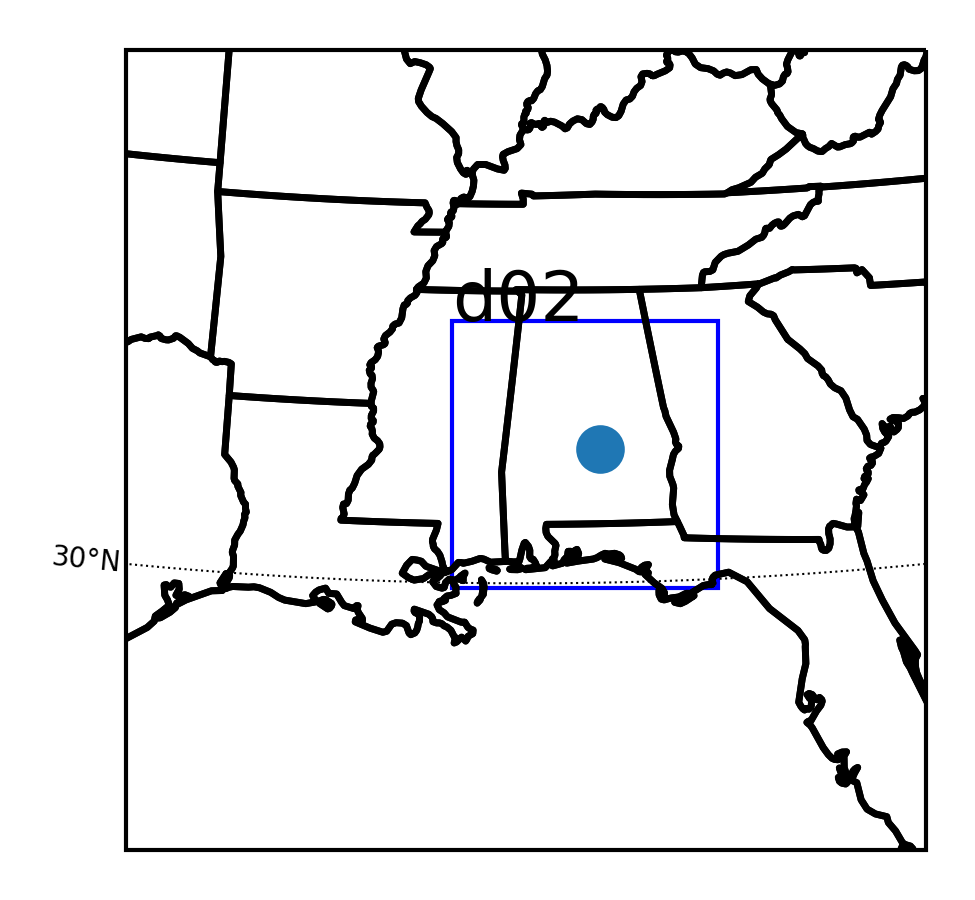

In [255]:
%matplotlib inline
create_map(info)
draw_d02(info)
draw_d03(info)

s = plt.scatter(tor_lon, tor_lat, transform=ccrs.PlateCarree())
#plt.gca().add_patch(s)

In [256]:
for i in info: 
    print(i)

dx
dy
max_dom
parent_grid_ratio
j_parent_start
i_parent_start
e_sn
e_we
ref_lat
ref_lon
true_lat1
true_lat2
